In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

## Data and Setup

In [5]:
# Load data
df = pd.read_csv("final_ndbc_data.csv")

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

n_past = 24   # past 24 hours
n_future = 24  # forecast 6 hours ahead

# Update sequence creation for multi-output y
def create_sequences(data, target_col, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :])
        y.append(data[i:i + n_future, target_col])  # output is a sequence
    return np.array(X), np.array(y)
# y now has shape (samples, 12)

X, y = create_sequences(scaled_data, target_col=0, n_past=n_past, n_future=n_future)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Functions

In [6]:
# Inverse Transform Function

# y_pred shape: (8136, 12) = 12 future steps for one feature
# We need to pad to shape (8136*12, 11) to use scaler.inverse_transform()
def inv_transform(y_pred, y_test):
    n_samples, n_steps = y_pred.shape
    n_features = scaled_data.shape[1]  # should be 11

    # Create empty arrays for full shape
    pred_full = np.zeros((n_samples * n_steps, n_features))
    actual_full = np.zeros_like(pred_full)

    # Put the predicted and true values into the correct column (e.g. WVHT at index 0)
    # Replace `0` with the index of the feature you're forecasting
    pred_full[:, 0] = y_pred.flatten()
    actual_full[:, 0] = y_test.flatten()

    # Inverse transform
    predicted_real_flat = scaler.inverse_transform(pred_full)[:, 0]
    actual_real_flat = scaler.inverse_transform(actual_full)[:, 0]

    # Reshape back to (n_samples, n_steps)
    predicted_real = predicted_real_flat.reshape(n_samples, n_steps)
    actual_real = actual_real_flat.reshape(n_samples, n_steps)
    
    return predicted_real, actual_real

In [7]:
# Error DF Function
def get_error_df(pred, real, n_future):
    errors = []
    for i in range(n_future):  
        forecast = pred[:, i]
        actual = real[:, i]

        mape_ = mean_absolute_percentage_error(actual, forecast)*100
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        r2 = r2_score(actual, forecast)

        errors.append({
            'Hour': i + 1,
            'R²': r2,
            'RMSE': rmse,
            'MAPE': mape_
        })

    # Convert to DataFrame
    error_df = pd.DataFrame(errors).set_index("Hour")
    return error_df

## XGBoost

In [8]:
# Flatten dimension for XGB
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

multi_model = MultiOutputRegressor(XGBRegressor())
multi_model.fit(X_train_xgb, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [9]:
y_pred_xgb = multi_model.predict(X_test_xgb)

In [10]:
# Inverse Transform
predicted_real_xgb, actual_real_xgb = inv_transform(y_pred_xgb, y_test)

In [23]:

error_df_xgb = get_error_df(predicted_real_xgb, actual_real_xgb, n_future)
error_df_xgb

,R²,RMSE,MAPE
Hour,,,
1,0.958844,0.132918,5.030792
2,0.927522,0.176387,8.029217
3,0.891031,0.216278,10.481591
4,0.842594,0.259935,12.643407
5,0.796450,0.295584,14.661423
6,0.750344,0.327343,16.432283
7,0.703323,0.356831,18.604532
8,0.641155,0.392439,19.337604
9,0.610507,0.408866,20.493563


## CNN + LSTM

In [14]:
# Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(n_future)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot loss
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.legend()
# plt.title("Training Loss Over Epochs")
# plt.show()

C:\Users\tarun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,248 (98.62 KB)

 Trainable params: 25,248 (98.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0128 - val_loss: 0.0071
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0051 - val_loss: 0.0065
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

In [15]:
# Predict
y_pred = model.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [16]:
# Inverse Transform
predicted_real, actual_real = inv_transform(y_pred, y_test)

In [17]:
# Real Metrics
mae = mean_absolute_error(actual_real, predicted_real)
rmse = np.sqrt(mean_squared_error(actual_real, predicted_real))
r2 = r2_score(actual_real, predicted_real)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MAE: 0.2887, RMSE: 0.4544, R²: 0.5194


In [18]:
error_df_NN = get_error_df(predicted_real, actual_real, n_future)
error_df_NN

,R²,RMSE,MAPE
Hour,,,
1,0.954320,0.140033,8.633153
2,0.929887,0.173485,10.394225
3,0.894797,0.212507,12.074940
4,0.856659,0.248050,13.638057
5,0.816094,0.280959,15.233852
6,0.770697,0.313717,16.802543
7,0.725752,0.343078,18.052156
8,0.682041,0.369406,19.165601
9,0.636001,0.395259,20.297119


## Comparison Plots

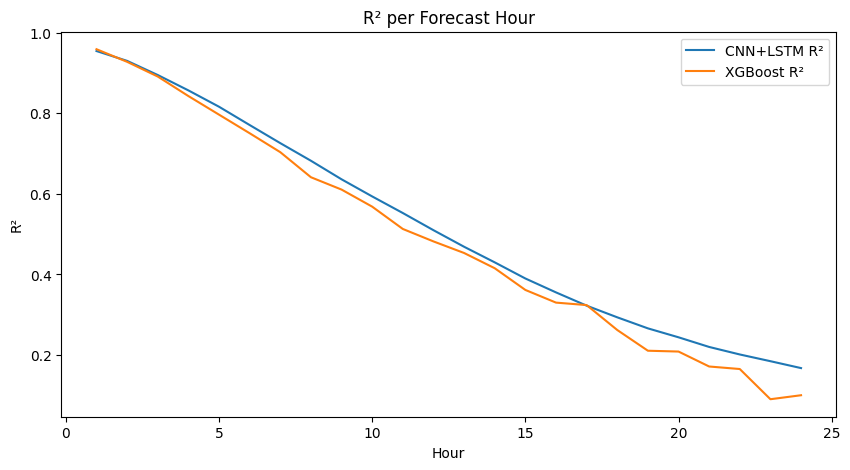

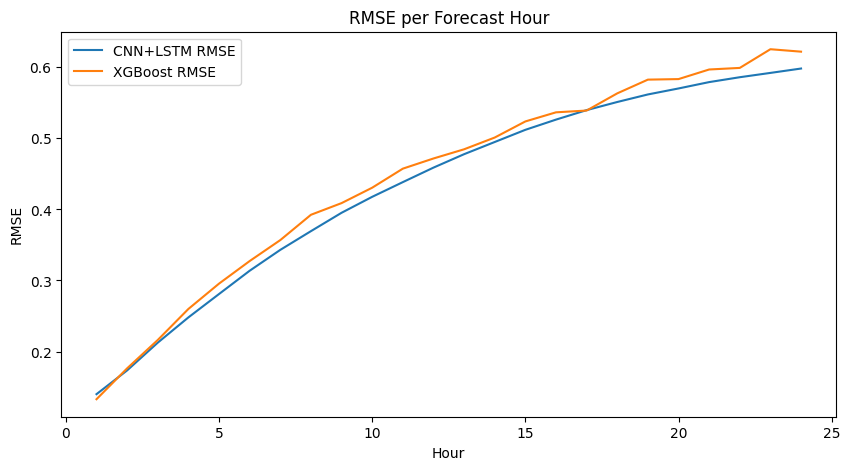

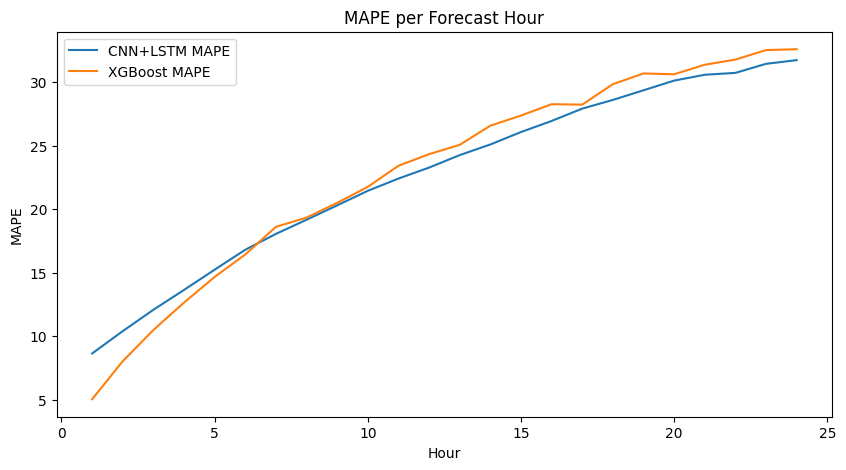

In [19]:
metrics = error_df_NN.columns

for metric in metrics:
    plt.figure(figsize=(10, 5))
    
    plt.plot(error_df_NN.index, error_df_NN[metric], label=f'CNN+LSTM {metric}')
    plt.plot(error_df_xgb.index, error_df_xgb[metric], label=f'XGBoost {metric}')
    
    plt.title(f'{metric} per Forecast Hour')
    plt.xlabel('Hour')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

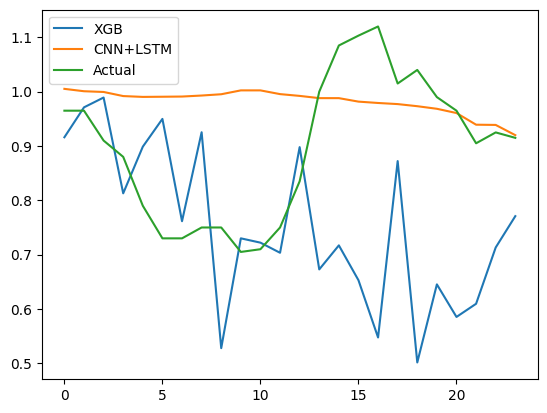

In [ ]:
# Example Forecast (note that each forecast is 24 hours, so i=1 and i=2 etc will be similar- go up in increments of at least 24)
i=800
plt.plot(predicted_real_xgb[i], label='XGB')
plt.plot(predicted_real[i], label = 'CNN+LSTM')
plt.plot(actual_real_xgb[i], label = 'Actual')
plt.legend()
plt.show()